# Object Localization with PyTorch:

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations;
!pip install timm;
!pip install --upgrade opencv-contrib-python;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-53zpomax
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-53zpomax
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [4]:
# import usefull libraries:

import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

## Configurations:

In [6]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'
DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140

#hyperparameters

LR = 0.0001342874
EPOCHS = 100
MODEL_NAME = 'efficientnet_b0'
N_JOBS = 4


In [7]:
data = pd.read_csv(CSV_FILE)
data

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


## Dataset understanding:

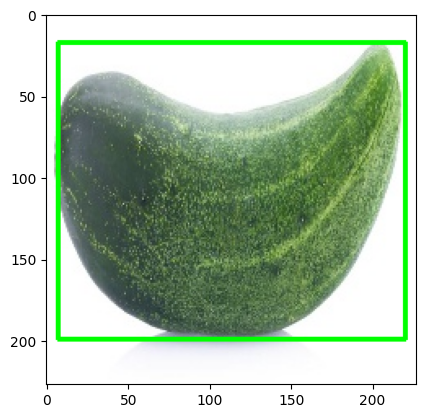

In [8]:
row = data.iloc[18]
img = cv2.imread(DATA_DIR + row[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plotting the bounding box:
vt1 = (row[1], row[2])
vt2 = (row[3], row[4])
bounding_box = cv2.rectangle(img,vt1, vt2, (0,255,0), 2)
plt.imshow(img)

In [9]:
# splitting data into training and validation

train_data, valid_data = train_test_split(data, test_size=0.20, random_state=42)


## Data Augmentation:

In [10]:
import albumentations as alb

#usefull librarie for image annotation and image segmentation


In [11]:
train_augmentation = alb.Compose([
        alb.Resize(IMG_SIZE, IMG_SIZE),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.Rotate()
], bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['class_labels']))


validation_augmentation = alb.Compose([
        alb.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['class_labels']))

## Custom augmented dataset

In [12]:
class ObjLocDataset(torch.utils.data.Dataset):
      def __init__(self, dataframe, augmentations = None):
            self.dataframe = dataframe
            self.augmentations = augmentations
      def __len__(self):
            return len(self.dataframe)
      def __getitem__(self, idx):
            row = self.dataframe.iloc[idx]

            x_min = row.xmin
            y_min = row.ymin
            x_max = row.xmax
            y_max = row.ymax

            bbox = [[x_min, y_min, x_max, y_max]]

            img_path = DATA_DIR + row.img_path
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            

            if self.augmentations:
                  _data = self.augmentations(image = img, bboxes=bbox, class_labels = [None])
                  img = _data['image']
                  bbox = _data['bboxes'][0]

            img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c) -> (c,h,w)
            bbox = torch.Tensor(bbox)

            return img, bbox



In [13]:
# creating the custom datasets:

trainset = ObjLocDataset(train_data, train_augmentation)
validset = ObjLocDataset(valid_data, validation_augmentation)

In [14]:
print(f'total training instances: {len(trainset)}')
print(f'total validation instances: {len(validset)}')

total training instances: 148
total validation instances: 38


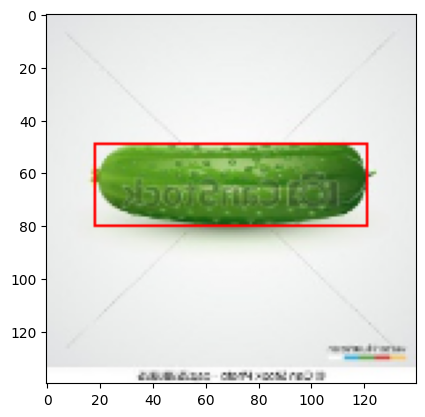

In [15]:
img, bbox = trainset[10]

xmin, ymin, xmax, ymax = bbox

vt1 = (int(xmin),int(ymin))
vt2 = (int(xmax),int(ymax))
color = (255,0,0)
linewidth = 1
bbx_img = cv2.rectangle(img.permute(1,2,0).numpy(), vt1, vt2,color, linewidth)

plt.imshow(bbx_img)

## creating a batched dataset

In [16]:
train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
print(f'total number of training batches: {len(train_data_loader)}')
print(f'total number of validation batches: {len(validation_data_loader)}')

total number of training batches: 10
total number of validation batches: 3


In [18]:
# inspecting tensor dimensions:

for image, bbox in train_data_loader:
  break;

print('image batch shape: ', image.shape)
print('bboxes batch shape: ', bbox.shape)

image batch shape:  torch.Size([16, 3, 140, 140])
bboxes batch shape:  torch.Size([16, 4])


## Creating the model:

here we will use a EfficientNetb0

In [19]:
from torch import nn
import timm


In [20]:
class ObjLocModel(nn.Module):
      def __init__(self):
            super(ObjLocModel, self).__init__()

            self.blueprint = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

      def forward(self, images, gt_bboxes=None):
            bboxes = self.blueprint(images)

            if gt_bboxes != None:
                  loss = nn.MSELoss()(bboxes, gt_bboxes)
                  return bboxes, loss
            return bboxes

In [21]:
model = ObjLocModel()
model.to(DEVICE);

In [22]:
# testing the model's output:

random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

## Writting the training and validation functions

In [23]:
def model_training(model, dataloader, optimizer):
       train_loss = 0.0

       model.train()

       for data in tqdm(dataloader):

            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

       return train_loss/len(dataloader)

In [24]:
def model_evaluation(model, dataloader):
       train_loss = 0.0

       model.eval()
       with torch.no_grad():
            for data in tqdm(dataloader):

                  images, gt_bboxes = data
                  images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

                  bboxes, loss = model(images, gt_bboxes)

                  train_loss += loss.item()

            return train_loss/len(dataloader)

## Creating the Training Loop

In [25]:
# instanciating the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
best_valid_loss = np.inf

for i in range(EPOCHS):

      training_loss = model_training(model, train_data_loader, optimizer)
      validation_loss = model_evaluation(model, validation_data_loader)

      if validation_loss < best_valid_loss:
          torch.save(model.state_dict(), 'best_mode.pt')
          print('BEST-WIGHTS-SAVED')
          best_valid_loss = validation_loss
      print(f'Epoch:{i+1} - train_loss: {training_loss} - val_loss: {validation_loss}')      

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:1 - train_loss: 7529.300244140625 - val_loss: 7240.76171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:2 - train_loss: 6486.92529296875 - val_loss: 6089.983072916667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:3 - train_loss: 5593.493505859375 - val_loss: 4486.170572916667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:4 - train_loss: 4225.466064453125 - val_loss: 2839.2730305989585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:5 - train_loss: 3564.6870849609377 - val_loss: 2191.6595865885415


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:6 - train_loss: 2842.857958984375 - val_loss: 2138.315958658854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:7 - train_loss: 2544.653112792969 - val_loss: 1922.4919840494792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:8 - train_loss: 2199.1732177734375 - val_loss: 1754.2622884114583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9 - train_loss: 1943.8804443359375 - val_loss: 1791.8124186197917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:10 - train_loss: 1834.810009765625 - val_loss: 1667.0146077473958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:11 - train_loss: 1589.1444702148438 - val_loss: 1401.2506917317708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:12 - train_loss: 1477.1150024414062 - val_loss: 1436.4507242838542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:13 - train_loss: 1366.3067993164063 - val_loss: 1211.4163818359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:14 - train_loss: 1194.959326171875 - val_loss: 1212.8634847005208


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:15 - train_loss: 1054.0050903320312 - val_loss: 1107.0984293619792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:16 - train_loss: 1049.9360412597657 - val_loss: 994.01123046875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:17 - train_loss: 1005.7180114746094 - val_loss: 863.9862467447916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:18 - train_loss: 946.2914978027344 - val_loss: 874.9619954427084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:19 - train_loss: 852.6934631347656 - val_loss: 830.8157552083334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:20 - train_loss: 844.2264038085938 - val_loss: 760.3173421223959


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:21 - train_loss: 802.3716552734375 - val_loss: 781.0970052083334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:22 - train_loss: 771.7600708007812 - val_loss: 820.8334147135416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:23 - train_loss: 705.2458251953125 - val_loss: 719.5502115885416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:24 - train_loss: 711.4252838134765 - val_loss: 773.0693359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:25 - train_loss: 669.3290344238281 - val_loss: 733.2009684244791


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:26 - train_loss: 664.8685668945312 - val_loss: 710.0222371419271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:27 - train_loss: 668.1845947265625 - val_loss: 677.3511962890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:28 - train_loss: 620.3908325195313 - val_loss: 684.6739908854166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:29 - train_loss: 598.8095489501953 - val_loss: 619.0021362304688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:30 - train_loss: 556.5087738037109 - val_loss: 587.358642578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:31 - train_loss: 477.92225036621096 - val_loss: 553.2673543294271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:32 - train_loss: 493.3701568603516 - val_loss: 543.2118326822916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:33 - train_loss: 486.7703399658203 - val_loss: 490.98839314778644


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:34 - train_loss: 474.0699127197266 - val_loss: 508.39390055338544


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:35 - train_loss: 475.8375518798828 - val_loss: 482.466064453125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:36 - train_loss: 472.24461975097654 - val_loss: 482.34714762369794


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:37 - train_loss: 396.1197937011719 - val_loss: 411.51719156901044


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:38 - train_loss: 399.6670166015625 - val_loss: 410.1514892578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:39 - train_loss: 362.8451187133789 - val_loss: 460.46766153971356


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:40 - train_loss: 340.93821105957034 - val_loss: 385.35325113932294


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:41 - train_loss: 350.77320251464846 - val_loss: 370.1398518880208


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:42 - train_loss: 324.01776123046875 - val_loss: 351.58984375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:43 - train_loss: 322.30065765380857 - val_loss: 360.52492268880206


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:44 - train_loss: 289.69300537109376 - val_loss: 331.54302978515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:45 - train_loss: 318.10130920410154 - val_loss: 332.34715779622394


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:46 - train_loss: 299.5964324951172 - val_loss: 316.34775797526044


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:47 - train_loss: 286.0146286010742 - val_loss: 302.3735860188802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:48 - train_loss: 270.0161163330078 - val_loss: 288.28515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:49 - train_loss: 256.8354522705078 - val_loss: 302.29542032877606


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:50 - train_loss: 249.90268096923828 - val_loss: 313.83437093098956


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:51 - train_loss: 264.5463806152344 - val_loss: 279.9215443929036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:52 - train_loss: 256.3202239990234 - val_loss: 313.1902770996094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:53 - train_loss: 234.59907989501954 - val_loss: 265.7683614095052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:54 - train_loss: 198.5920669555664 - val_loss: 223.74278767903647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:55 - train_loss: 235.8301254272461 - val_loss: 240.48168436686197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:56 - train_loss: 200.25194702148437 - val_loss: 238.55502319335938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:57 - train_loss: 186.3733901977539 - val_loss: 248.73480733235678


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:58 - train_loss: 161.3858383178711 - val_loss: 253.00098673502603


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:59 - train_loss: 180.45039978027344 - val_loss: 220.2079111735026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:60 - train_loss: 167.95341300964355 - val_loss: 193.322509765625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:61 - train_loss: 177.0337875366211 - val_loss: 194.83324178059897


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:62 - train_loss: 173.51176910400392 - val_loss: 193.58793131510416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:63 - train_loss: 166.02384414672852 - val_loss: 178.11724853515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:64 - train_loss: 146.71225662231444 - val_loss: 182.9624989827474


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:65 - train_loss: 147.6812431335449 - val_loss: 169.03278605143228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:66 - train_loss: 121.10435409545899 - val_loss: 156.67576599121094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:67 - train_loss: 128.8891456604004 - val_loss: 156.22882080078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:68 - train_loss: 105.89928817749023 - val_loss: 131.95961252848306


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:69 - train_loss: 121.48635482788086 - val_loss: 152.7736612955729


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:70 - train_loss: 101.23243026733398 - val_loss: 149.23980712890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:71 - train_loss: 117.18506050109863 - val_loss: 139.27750651041666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:72 - train_loss: 123.2617790222168 - val_loss: 136.8602498372396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:73 - train_loss: 96.60805892944336 - val_loss: 140.81402587890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:74 - train_loss: 97.41775245666504 - val_loss: 147.4843292236328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:75 - train_loss: 104.84143371582032 - val_loss: 135.7247111002604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:76 - train_loss: 97.73698806762695 - val_loss: 163.4234161376953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:77 - train_loss: 83.79547996520996 - val_loss: 118.23180389404297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:78 - train_loss: 84.50963516235352 - val_loss: 101.09000142415364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:79 - train_loss: 89.70071525573731 - val_loss: 104.54107411702473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:80 - train_loss: 70.42978096008301 - val_loss: 113.26739756266277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:81 - train_loss: 59.816606521606445 - val_loss: 95.60318756103516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:82 - train_loss: 76.6518980026245 - val_loss: 90.85432434082031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:83 - train_loss: 79.58427238464355 - val_loss: 101.53001658121745


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:84 - train_loss: 78.60420227050781 - val_loss: 100.69130452473958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:85 - train_loss: 61.29381904602051 - val_loss: 93.70020039876302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:86 - train_loss: 64.72791061401367 - val_loss: 78.12205505371094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:87 - train_loss: 61.3714542388916 - val_loss: 88.8125737508138


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:88 - train_loss: 61.07751998901367 - val_loss: 103.49973805745442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:89 - train_loss: 62.98969650268555 - val_loss: 92.14687856038411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:90 - train_loss: 56.32221584320068 - val_loss: 81.21408335367839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:91 - train_loss: 51.74272842407227 - val_loss: 91.86615753173828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:92 - train_loss: 62.19008865356445 - val_loss: 93.14737701416016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:93 - train_loss: 64.68663215637207 - val_loss: 80.14809672037761


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:94 - train_loss: 56.08013687133789 - val_loss: 80.9896952311198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

BEST-WIGHTS-SAVED
Epoch:95 - train_loss: 40.293727493286134 - val_loss: 68.2284049987793


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:96 - train_loss: 49.524100112915036 - val_loss: 70.76985168457031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:97 - train_loss: 49.06425876617432 - val_loss: 76.76665369669597


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:98 - train_loss: 54.92118968963623 - val_loss: 92.70642344156902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:99 - train_loss: 54.54917259216309 - val_loss: 73.20659891764323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:100 - train_loss: 53.96598873138428 - val_loss: 101.08346811930339


## Making predictions

In [34]:
import utils

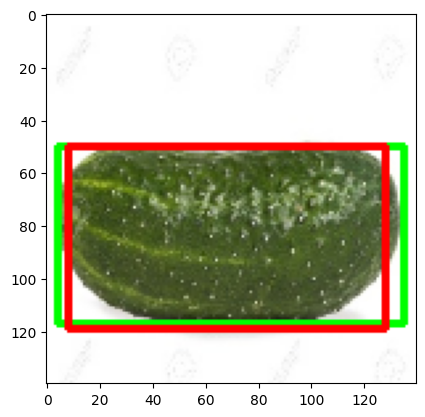

In [40]:
model.load_state_dict(torch.load('best_mode.pt'))
model.eval()

with torch.no_grad():
      
      image, gt_bbox = validset[3] #(c, h, w)

      image = image.unsqueeze(0).to(DEVICE) #(bs, c, h, w)
      out_bbox = model(image)
      # compare two images by plotting one over the other, here the green bbox is the truth bounding box.
      utils.compare_plots(image, gt_bbox, out_bbox);